In [143]:
#IMPORTING THE REQUIRED FUMCTIONS
import cv2
import time
import numpy as np
import matplotlib.pyplot as pl
import tensorflow
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [144]:
#LOADING THE IMAGE
img_array = np.load('../input/imagesnpy/Part 1- Train data - images.npy',allow_pickle=True)

In [145]:
#TAKING THE INFORMATION OF IMAGES AND DISCRIPTION INT TWO DIFFERENT ARRAYS
all_images_array = []
all_disc_array = []
arr = []
for i in range(0,272):
    img_shape = img_array[i][0].shape[2]
    if img_shape == 3:
        all_images_array.append(img_array[i][0])
        all_disc_array.append(img_array[i][1])
    else:
        print( i ,img_array[i][0].shape)
        
for i in range(273,len(img_array)):
    img_shape = img_array[i][0].shape[2]
    if img_shape == 3:
        all_images_array.append(img_array[i][0])
        all_disc_array.append(img_array[i][1])
    else:
        print(i , img_array[i][0].shape)

print(len(all_disc_array))

1 (697, 1280, 4)
3 (291, 600, 4)
41 (340, 516, 4)
49 (600, 800, 4)
64 (312, 750, 4)
140 (330, 538, 4)
151 (496, 860, 4)
247 (379, 505, 4)
263 (400, 770, 4)
337 (267, 740, 4)
347 (281, 600, 4)
397


In [147]:
a = img.shape[2]
print(a)

3


In [148]:
#RETURNS THE GREYSCALE IMAGE OF THE MASK FOR THE SEMANTIC SEGMENTATION. THIS IS PADDED ON TO THE MODEL IS Y_TRUE
def result(image,attr):
    totalfaces = 0
    im_c = np.full(image.shape,0,dtype = np.uint8)
    im_c = np.array(im_c, dtype=np.uint8)
    #img = np.array(img, dtype=np.uint8)
    for data in attr:
        height = data['imageHeight']
        width = data['imageWidth']
        points = data['points']
        if 'Face' in data['label']:
            x1 = round(width*points[0]['x'])
            y1 = round(height*points[0]['y'])
            x2 = round(width*points[1]['x'])
            y2 = round(height*points[1]['y'])
            cv2.rectangle(im_c, (x1, y1), (x2, y2), (255, 255, 255), -1)
            totalfaces += 1
    gray = cv2.cvtColor(im_c, cv2.COLOR_BGR2GRAY)        
    im = cv2.resize(image, (128,128), interpolation = cv2.INTER_AREA)
    gray = cv2.resize(gray, (128,128), interpolation = cv2.INTER_AREA)
    return im,gray

397
(128, 128, 3)


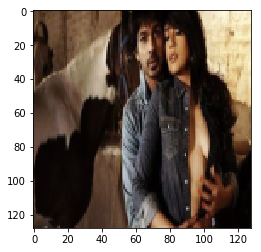

In [149]:
#SHOW SAMPLE INPUT AND OUTPUT
#i = 200
print(len(all_images_array))
image,gray = result(all_images_array[1],all_disc_array[1])
#np.array(image,np.int32)
print(image.shape)
plt.imshow(image)

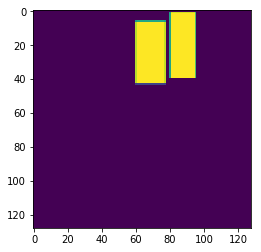

In [150]:
plt.imshow(gray)

In [151]:
gray.shape

(128, 128)

In [152]:
#ADDING ALL THE IMAGES AND THEIR SEGMENTATIONS INTO THE RESPECTIVE ARRAYS
new_images_array = []
new_seg_array = []
for i in range(0,len(all_images_array)):
    #print(i)
    image,gray = result(all_images_array[i],all_disc_array[i])
    new_images_array.append(image)
    new_seg_array.append(gray)

'for i in range(300,400):\n    #print(i)\n    image,gray = result(all_images_array[i],all_disc_array[i])\n    new_images_array.append(image)\n    new_seg_array.append(gray)'

(128, 128, 3)
(128, 128)


397

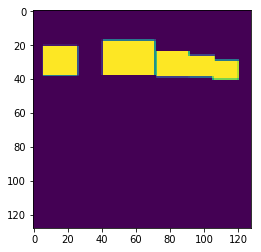

In [156]:
#SHOWING THE USER O/P
print(new_images_array[10].shape)
print(new_seg_array[0].shape)
plt.imshow(new_seg_array[9])
len(new_images_array)

In [157]:
#TEST-TRAIN SPLIT BY CREATING NUMPY MATRIXES
images_ = np.expand_dims(new_images_array[0], axis=0)
print(len(new_images_array))
a = []
b = []
X = np.zeros([len(new_images_array),128,128,3])
Y = np.zeros([len(new_images_array),128,128])
for i in range(0,len(new_images_array)):
    X[i] = new_images_array[i]
    Y[i] = new_seg_array[i]
    
print(X.shape)
print(Y.shape)

X_train = X[0:350]
X_test = X[350:397]
Y_train = Y[0:350]
Y_test = Y[350:397]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

397
(397, 128, 128, 3)
(397, 128, 128)
(350, 128, 128, 3)
(350, 128, 128)
(47, 128, 128, 3)
(47, 128, 128)


In [160]:
Y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [161]:
#MODEL BASIC FUNCTIONS
import tensorflow
acc = tensorflow.keras.layers.LeakyReLU(alpha=0.3)
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=acc)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=acc)(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=acc)(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=acc)(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=acc)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=acc)(c)
    return c

In [162]:
#CORE MODEL FUNCTIONS
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [163]:
#COMPILATION AND SUMMARY OF MODEL
image_size = 128
model = UNet()
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc",'mean_squared_error'])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_218 (Conv2D)             (None, 128, 128, 16) 448         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_218[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_47 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_219[0][0]                 
___________________________________________________________________________________________

In [164]:
#TRAINING THE MODEL
model.fit(X_train,Y_train,epochs=250)

Train on 350 samples
Epoch 1/250
350/350 [==============================] - 2s 7ms/sample - loss: 19041.7919 - acc: 0.0899 - mean_squared_error: 282272956416.0000
Epoch 2/250
350/350 [==============================] - 1s 2ms/sample - loss: 149.7432 - acc: 0.8557 - mean_squared_error: 181258.6562
Epoch 3/250
350/350 [==============================] - 1s 2ms/sample - loss: 165.6740 - acc: 0.8557 - mean_squared_error: 175543.9531
Epoch 4/250
350/350 [==============================] - 1s 2ms/sample - loss: 182.5493 - acc: 0.8557 - mean_squared_error: 156226.8906
Epoch 5/250
350/350 [==============================] - 1s 2ms/sample - loss: 319.5219 - acc: 0.8556 - mean_squared_error: 137083.3594
Epoch 6/250
350/350 [==============================] - 1s 2ms/sample - loss: 358.6021 - acc: 0.8556 - mean_squared_error: 137862.5312
Epoch 7/250
350/350 [==============================] - 1s 2ms/sample - loss: 1602.1499 - acc: 0.8553 - mean_squared_error: 70794.0000
Epoch 8/250
350/350 [============

In [165]:
#SAVING THE WEIGHTS AND PREDICTION FOR X_TEST
model.save_weights("model_weights.h5")
a = model.predict(X_test)

In [166]:
#CONVERTING THE PREDICTED IMAGE FROM 28X28X1 T0 28X28
pred = []
for image in a:
    im = image[:,:,0]
    pred.append(im)

In [218]:
#MANIPULATE THE VALUES TILL 40 VALUES
i = 1
j = i + 350

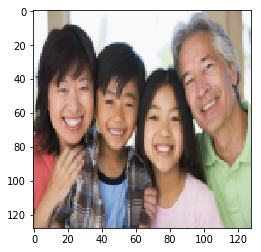

In [219]:
plt.imshow(new_images_array[j])

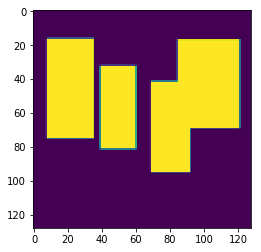

In [220]:
plt.imshow(new_seg_array[j])

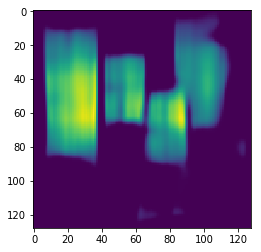

In [221]:
plt.imshow(pred[i])

In [210]:
#CUSTOM FUNCTION FOR LOSS
import numpy as np
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    intersection = 0
    union = 0
    for i in range(0,len(y_true)):
        intersection += y_true[i]*y_pred[i]
    a = y_pred + y_true
    for i in a:
        union += 0
        
    dice = (2. * intersection + smooth)/(union + smooth)
    
    return dice

y_true = new_seg_array[j].ravel()
y_pred = pred[i].ravel()

res = dice_coef(y_true,y_pred,smooth=1)
print(res)

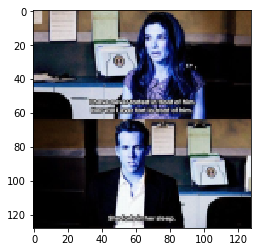

In [226]:
a1 = cv2.imread('../input/test-image/Part 1Test Data - Prediction Image.jpeg')
im_ = cv2.resize(a1, (128,128), interpolation = cv2.INTER_AREA)
images_ = np.expand_dims(im_, axis=0)
images_.shape
img_pred = model.predict(images_)
image = img_pred[0]
im = image[:,:,0]
im.shape
plt.imshow(im_)

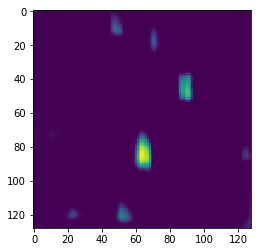

In [227]:
#PLEASE NOTE THAT RYAN RONALDS IS BEING NOTICED BUT SANDRA BULLOCK IS NOT THAT EFFECTIVELY 
#THIS CAN BE ATTRIBUTED TO BLUURY NATURE OF THE PICTURE DUE TO RESIZE
plt.imshow(im)